# ML Final Project

### Tanay, Vishal, Nikshita, Garv

## About the Dataset

The data contains information about passengers on a "Spaceship Titanic", including which deck of the ship, room number, their names and ages, and their origin and destination. Given this information, we are supposed to predict whether that passenger has survived or died on this Spaceship Titanic after it has crashed with a space anomoly. This matters so that for future space ventures, the company knows where to increase safety engineering on their ship, and also possibly adjust prices for the different rooms on the ship based on what class of passengers and rooms have survived.

### Attributes in the Dataset
`PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

`HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.

`CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

`Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

`Destination` - The planet the passenger will be debarking to.

`Age` - The age of the passenger.

`VIP` - Whether the passenger has paid for special VIP service during the voyage.

`RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

`Name` - The first and last names of the passenger.

`Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [134]:
# !pip install scikit-learn matplotlib numpy pandas tensorflow

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn 
from pandas import DataFrame
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline

df = pd.read_csv("train.csv")

# Data Exploration and Cleaning

In [136]:
# Checking how many NaNs there are 
rows_with_nan = df.isnull().any(axis=1).sum()
rows_without_nan = len(df) - rows_with_nan

print(f"Rows with NaN: {rows_with_nan}")
print(f"Rows without NaN: {rows_without_nan}")

print("Columns with NaNs: ", df.isnull().any())

# Checking what the data looks like
df.head()

Rows with NaN: 2087
Rows without NaN: 6606
Columns with NaNs:  PassengerId     False
HomePlanet       True
CryoSleep        True
Cabin            True
Destination      True
Age              True
VIP              True
RoomService      True
FoodCourt        True
ShoppingMall     True
Spa              True
VRDeck           True
Name             True
Transported     False
dtype: bool


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# Data Cleaning and Exploration

Rationale: Based on the results of our data exploration, we have decided to process the data in the following ways: Initially, we planned on dropping all 2087 records with NaNs, but we later revisited this as the accuracies we were getting from our models was not as high as we thought it could be, and we felt that more data could help with this. Thus, we decided to impute numerical features with the mean for the feature, and categorical features with the the value that best fits the probability distribution. We did not impute binary features as we felt that since there were only 2 possible values, imputation was risky and could drastically impact the output if the value was off. In the end, we dropped 786 records with NaNs, leaving 7907 records left, We will revisit this if necessary. We will one hot encode the HomePlanet and Destination fields as they are categorical. We will drop the Name field since it is unique (or near unique) for each passenger, and it seems unlikely it could provide useful information. As the Cabin field essentially has three pieces of information (deck, number, and side), we have elected to break it down into three fields. Similarly, as the Passenger_Id field has two pieces of information (group number and passenger number), we will break it down into two fields. We will one hot encode the deck as it has only a handful of options. We will convert the new side feature from P or S into True or False. For all numeric features (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck Age, Room, Group, PassengerNumber), we will standardize the values so that  we can conduct PCA. Lastly, we will conduct PCA on the data.

In [153]:
imputed_df = df

print("Columns with NaNs before imputation: ", imputed_df.columns[imputed_df.isnull().any()].tolist())

# fill NaNs in HomePlanet with random values based on distribution
value_counts = imputed_df['HomePlanet'].value_counts(normalize=True)
imputed_df["HomePlanet"] = imputed_df["HomePlanet"].fillna(lambda: np.random.choice(value_counts.index, p=value_counts.values))

# fill NaNs in Destination with random values based on distribution
value_counts = imputed_df['Destination'].value_counts(normalize=True)
imputed_df["Destination"] = imputed_df["Destination"].fillna(lambda: np.random.choice(value_counts.index, p=value_counts.values))

# Impute RoomService with the mean
imputed_df["RoomService"] = imputed_df["RoomService"].fillna(imputed_df["RoomService"].mean())

# Impute FoodCourt with the mean
imputed_df["FoodCourt"] = imputed_df["FoodCourt"].fillna(imputed_df["FoodCourt"].mean())

# Impute ShoppingMall with the mean
imputed_df["ShoppingMall"] = imputed_df["ShoppingMall"].fillna(imputed_df["ShoppingMall"].mean())

# Impute Spa with the mean
imputed_df["Spa"] = imputed_df["Spa"].fillna(imputed_df["Spa"].mean())

# Impute VRDeck with the mean
imputed_df["VRDeck"] = imputed_df["VRDeck"].fillna(imputed_df["VRDeck"].mean())

# Impute Age with the mean
imputed_df['Age'] = imputed_df['Age'].fillna(imputed_df['Age'].mean())

# drop NaNs
processed_features = imputed_df.dropna()

# Drop Name values
imputed_df = imputed_df.drop(columns=['Name'])

# Split Cabin values into three columns
imputed_df[["Deck", "Room", "Side"]] = imputed_df['Cabin'].str.split("/", expand=True)
imputed_df = imputed_df.drop(columns=['Cabin'])
imputed_df.head()

# Split Passenger values into two columns
imputed_df[["Group", "Passenger_Number"]] = imputed_df['PassengerId'].str.split("_", expand=True)
imputed_df = imputed_df.drop(columns=['PassengerId'])
imputed_df.head()

print("Columns with NaNs after imputation: ", imputed_df.columns[imputed_df.isnull().any()].tolist())

Columns with NaNs before imputation:  ['CryoSleep', 'Cabin', 'VIP', 'Name']
Columns with NaNs after imputation:  ['CryoSleep', 'VIP', 'Deck', 'Room', 'Side']


In [146]:
processed_df = imputed_df

# One hot encode the HomePlanet
processed_df = pd.get_dummies(processed_df, columns=["HomePlanet"])

# One hot encode the DestinationPlanet
processed_df = pd.get_dummies(processed_df, columns=["Destination"])

# One hot encode the Deck
processed_df = pd.get_dummies(processed_df, columns=["Deck"])

# convert Side to T or F
processed_df["Side"] = processed_df['Side'].map({'P': True, 'S' : False})

# normalizing numeric features
scaler = StandardScaler()
processed_df['RoomService'] = scaler.fit_transform(processed_df[['RoomService']])
processed_df['FoodCourt'] = scaler.fit_transform(processed_df[['FoodCourt']])
processed_df['ShoppingMall'] = scaler.fit_transform(processed_df[['ShoppingMall']])
processed_df['Spa'] = scaler.fit_transform(processed_df[['Spa']])
processed_df['VRDeck'] = scaler.fit_transform(processed_df[['VRDeck']])
processed_df['Age'] = scaler.fit_transform(processed_df[['Age']])
processed_df['Group'] = scaler.fit_transform(processed_df[['Group']])
processed_df['Passenger_Number'] = scaler.fit_transform(processed_df[['Passenger_Number']])

rows_with_nan = processed_df.isnull().any(axis=1).sum()
rows_without_nan = len(processed_df) - rows_with_nan

print(f"Rows with NaN: {rows_with_nan}")
print(f"Rows without NaN: {len(processed_df) - rows_with_nan}")

processed_df = processed_df.dropna()

rows_with_nan = processed_df.isnull().any(axis=1).sum()
rows_without_nan = len(processed_df) - rows_with_nan

print(f"Rows with NaN: {rows_with_nan}")
print(f"Rows without NaN: {len(processed_df) - rows_with_nan}")

labels = processed_df["Transported"]
processed_features = processed_df.drop(labels = "Transported", axis="columns")

pca = PCA(n_components=0.95, svd_solver='full')
pca_data = pca.fit_transform(processed_features)
pca_df = DataFrame(pca_data)

print("Original data shape:", processed_features.shape)
print("Transformed data shape:", pca_df.shape)

processed_features.head()

Rows with NaN: 599
Rows without NaN: 8094
Rows with NaN: 0
Rows without NaN: 8094
Original data shape: (8094, 28)
Transformed data shape: (8094, 1)


,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Room,Side,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T
0,False,0.709437,False,-0.340590,-0.287314,-0.290817,-0.276663,-0.269023,0,True,...,False,True,False,True,False,False,False,False,False,False
1,False,-0.336717,False,-0.175364,-0.281669,-0.248968,0.211505,-0.230194,0,False,...,False,True,False,False,False,False,False,True,False,False
2,False,2.034566,True,-0.275409,1.955616,-0.290817,5.694289,-0.225782,0,False,...,False,True,True,False,False,False,False,False,False,False
3,False,0.290975,False,-0.340590,0.517406,0.330225,2.683471,-0.098708,0,False,...,False,True,True,False,False,False,False,False,False,False
4,False,-0.894666,False,0.118709,-0.243409,-0.038048,0.225732,-0.267258,1,False,...,False,True,False,False,False,False,False,True,False,False


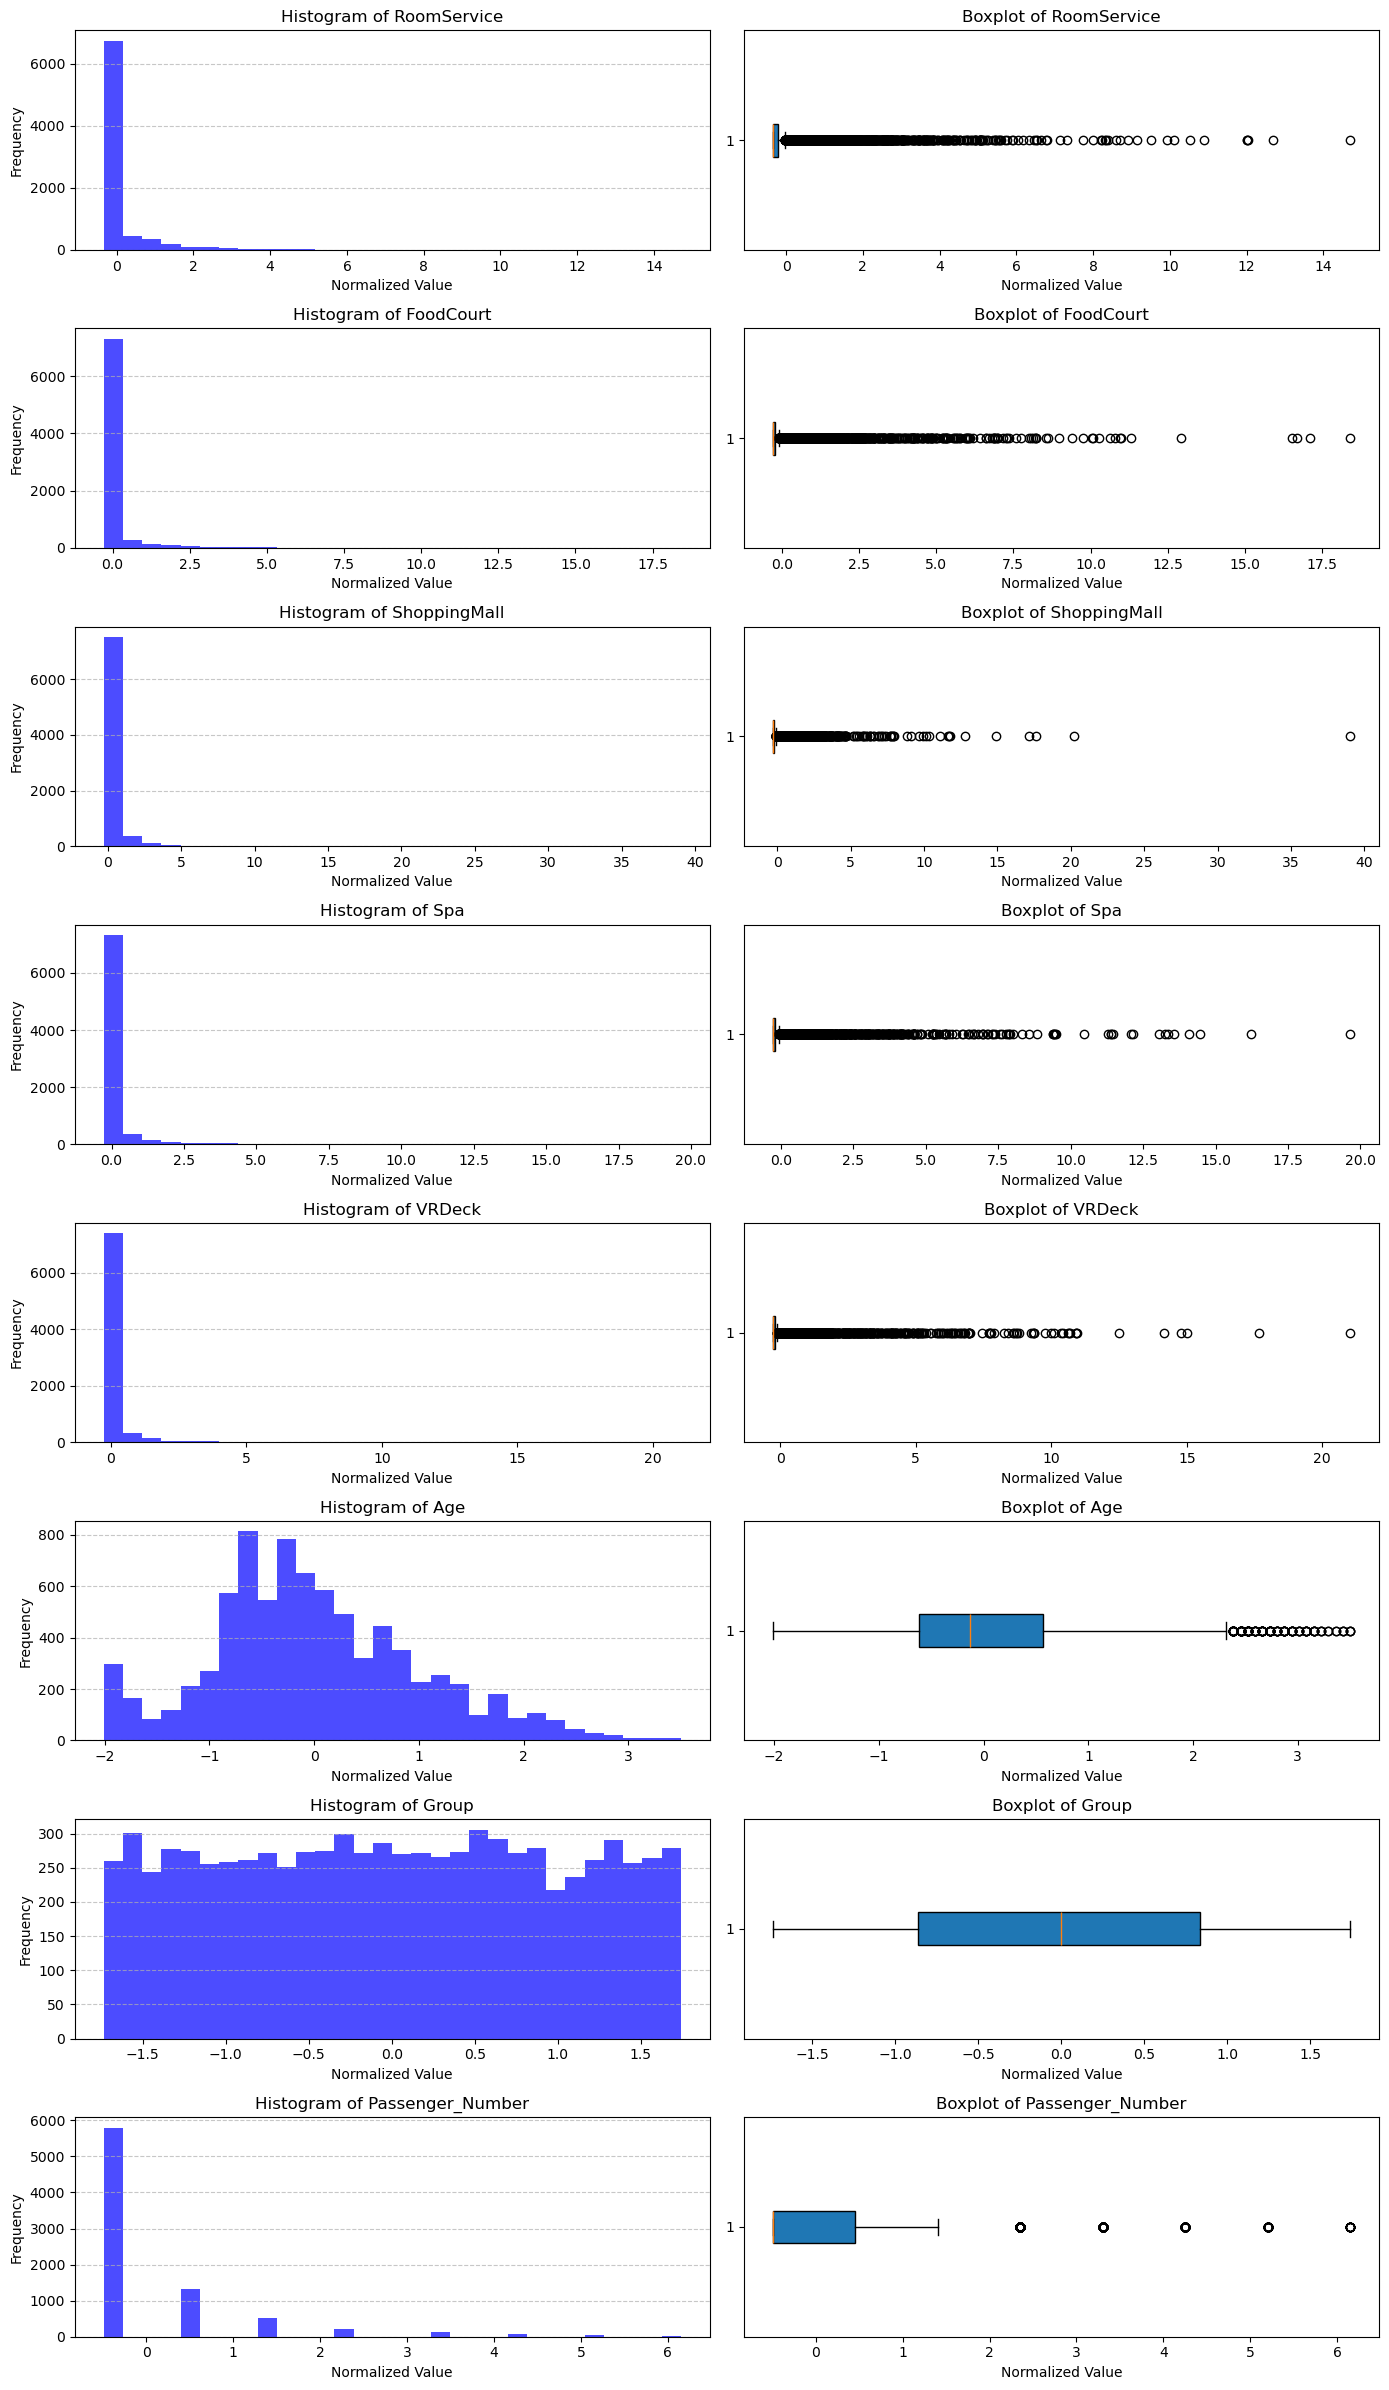

In [ ]:
# List of features to plot
features_to_plot = [
    'RoomService', 'FoodCourt', 'ShoppingMall', 
    'Spa', 'VRDeck', 'Age', 
    'Group', 'Passenger_Number'
]

# Create subplots for histograms and boxplots
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(14, 24))  # 8 rows, 2 columns
axes = axes.flatten()  # Flatten axes for easier iteration

# Plot both histograms and boxplots
for i, feature in enumerate(features_to_plot):
    # Plot histogram
    axes[2 * i].hist(processed_features[feature], bins=30, color='blue', alpha=0.7)
    axes[2 * i].set_title(f"Histogram of {feature}")
    axes[2 * i].set_xlabel("Normalized Value")
    axes[2 * i].set_ylabel("Frequency")
    axes[2 * i].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot boxplot
    axes[2 * i + 1].boxplot(processed_features[feature], vert=False, patch_artist=True)
    axes[2 * i + 1].set_title(f"Boxplot of {feature}")
    axes[2 * i + 1].set_xlabel("Normalized Value")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


[Text(0, 0.5, 'HomePlanet_Europa'),
 Text(0, 1.5, 'HomePlanet_Earth'),
 Text(0, 2.5, 'Room'),
 Text(0, 3.5, 'Deck_G'),
 Text(0, 4.5, 'Deck_F'),
 Text(0, 5.5, 'HomePlanet_Mars'),
 Text(0, 6.5, 'Deck_C'),
 Text(0, 7.5, 'Deck_B'),
 Text(0, 8.5, 'CryoSleep'),
 Text(0, 9.5, 'FoodCourt'),
 Text(0, 10.5, 'Destination_55 Cancri e'),
 Text(0, 11.5, 'Destination_TRAPPIST-1e'),
 Text(0, 12.5, 'Transported'),
 Text(0, 13.5, 'VRDeck'),
 Text(0, 14.5, 'Spa'),
 Text(0, 15.5, 'Destination_PSO J318.5-22'),
 Text(0, 16.5, 'Age'),
 Text(0, 17.5, 'Deck_D'),
 Text(0, 18.5, 'Deck_A'),
 Text(0, 19.5, 'RoomService'),
 Text(0, 20.5, 'Deck_E'),
 Text(0, 21.5, 'VIP'),
 Text(0, 22.5, 'Passenger_Number'),
 Text(0, 23.5, 'ShoppingMall'),
 Text(0, 24.5, 'Group'),
 Text(0, 25.5, 'HomePlanet_<function <lambda> at 0x31797be20>'),
 Text(0, 26.5, 'Destination_<function <lambda> at 0x31797ba60>'),
 Text(0, 27.5, 'Side'),
 Text(0, 28.5, 'Deck_T')]

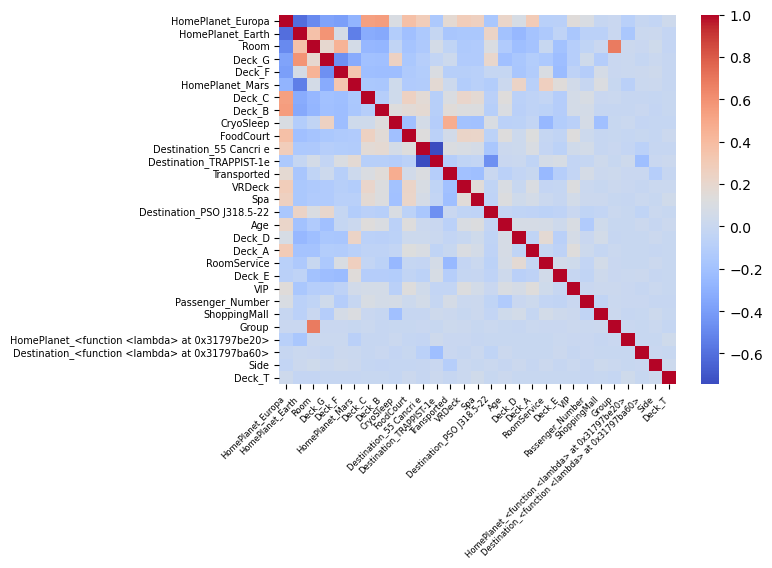

In [154]:
correlation = processed_df.corr()

sorted_indices = correlation.abs().mean().sort_values(ascending=False).index  # Sort by average absolute correlation
sorted_correlation = correlation.loc[sorted_indices, sorted_indices]

ax = sns.heatmap(sorted_correlation, fmt=".2f", cmap="coolwarm")

# Display all attributes
ax.set_xticks(np.arange(len(sorted_correlation.columns)) + 0.5, minor=False)
ax.set_yticks(np.arange(len(sorted_correlation.index)) + 0.5, minor=False)

# Assign proper labels to all ticks
ax.set_xticklabels(sorted_correlation.columns, fontsize=6, rotation=45, ha="right")  # Rotate x-axis labels
ax.set_yticklabels(sorted_correlation.index, fontsize=7)

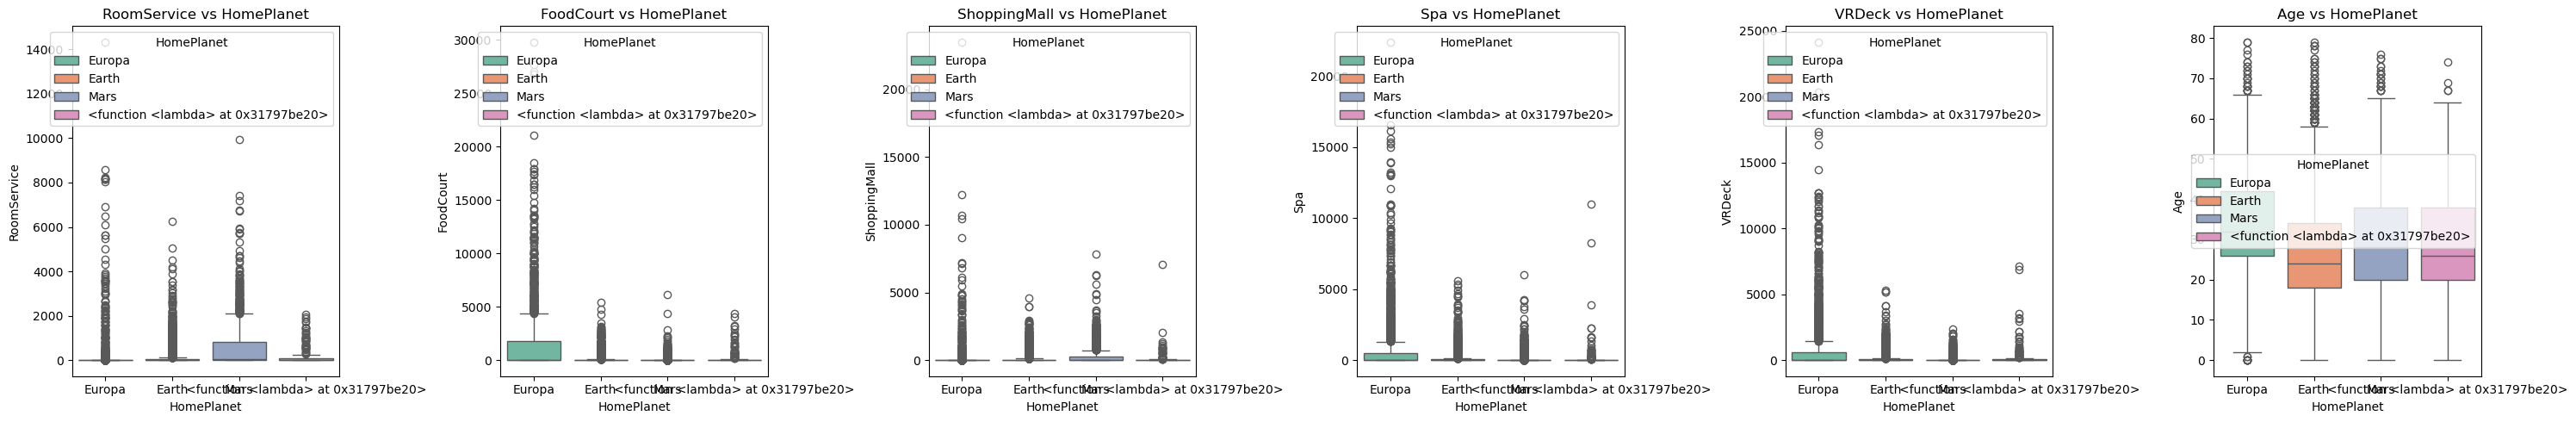

In [155]:
attributes = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Age"]
n_plots = len(attributes)

fig, axes = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5), sharey=False)

for i, attribute in enumerate(attributes):
    sns.boxplot(
        data=imputed_df,
        x="HomePlanet",
        y=attribute,
        palette="Set2",
        ax=axes[i],
        hue="HomePlanet"
    )
    axes[i].set_title(f"{attribute} vs HomePlanet")
    axes[i].set_xlabel("HomePlanet")

plt.tight_layout()
plt.show()

We thought there would be a correlation between the HomePlanet and a few different attributes, but what I found that the data is all over the place. The only real outliers that I found was that Europa tended to spend a lot more on the food court and spa more.

# Model Training

### Decision Tree Model

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score

param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [5, 10, 15, 20],
    'max_features': [5, 10, 15],
    'criterion': ['gini', 'entropy']
}
clf = DecisionTreeClassifier()

# runs the nested cross validation
acc = cross_val_score(GridSearchCV(clf, param_grid, cv=5), X=pca_df, y=labels, cv=10)
print(acc.mean() * 100)


75.27600057610138


### KNN

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

ss = StandardScaler()
pca = PCA()
knn = KNeighborsClassifier()

pipeline = Pipeline([
    ('scaler', ss),
    ('pca', pca),
    ('knn', knn),
])

param_grid = {
    'pca__n_components': list(range(1, 11)),
    'knn__n_neighbors': list(range(1, 10))
}

inner_cv = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
acc = cross_val_score(inner_cv, X=pca_df, y=labels, cv=5)

print(acc.mean() * 100)

73.3658544776746


### Support Vector Machine

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
import sklearn as sk

pipeline = Pipeline([
    ('scaler', ss),
    ('pca', pca),
    ('svc', SVC())
])

params_grid = {
    'pca__n_components': list(range(5, 19)),
    'svc__kernel': ['linear', 'rbf', 'poly']
}

inner_cv = GridSearchCV(pipeline, params_grid, cv=5, scoring='accuracy')
label_preds = cross_val_predict(inner_cv, X=pca_df, y=labels, cv=10)

class_report = sk.metrics.classification_report(labels, label_preds)
print("\nClassification Report:\n", class_report)
# Accuracy is in the classification report


Classification Report:
               precision    recall  f1-score   support

       False       0.74      0.83      0.78      3928
        True       0.81      0.72      0.76      3979

    accuracy                           0.77      7907
   macro avg       0.78      0.77      0.77      7907
weighted avg       0.78      0.77      0.77      7907



In [ ]:
# Necessary Imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Build the model
X_train, X_test, y_train, y_test = train_test_split(pca_df, labels, test_size=0.2)

model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dense(32, activation='relu'),
    # Output layer for binary classification
    Dense(1, activation='sigmoid')  
])

# Train Model
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Evaluation
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Print Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

ValueError: Found input variables with inconsistent numbers of samples: [7907, 8693]